In [ ]:
# The genetic algorithm, tournament selection and single point crossover functions 
# and plotting the fitness were taken from EVO Lab 2. Author - Ing. Martin Hurta

import numpy as np
import matplotlib.pyplot as plt
import random
from math import ceil

In [ ]:
# BIN extension----------------------------------------------------------------------
def generate_graph(n):
  print("Generating adjacency matrix...")
  num_vertices = n 
  graph = [[0] * num_vertices for _ in range(num_vertices)]
  num_edges = 0 

  while(num_edges != int( (num_vertices**2)/4*3/2 )):
      vertex1, vertex2 = random.sample(range(num_vertices),2)
      if(graph[vertex1][vertex2] != 1):
        graph[vertex1][vertex2] = 1
        graph[vertex2][vertex1] = 1
        num_edges += 1

  print(f"done! Graph has {num_vertices} vertices and {num_edges} edges")

  return graph, num_edges, num_vertices

def compute_upper_bound(fitness_value, edges, vertices, current_upper=float('inf')):
  initial_upper = ceil(edges / (vertices - 1))
  if fitness_value == 0 and current_upper <= initial_upper:
    return current_upper - 2
  else:
    return initial_upper

graph, num_edges, num_vertices = generate_graph(25)
num_BIN = compute_upper_bound(0, num_edges, num_vertices)
print(f"Chromatic number upper bound is {num_BIN}")

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
print(check_symmetric(np.array(graph)))

Generating adjacency matrix...
done! Graph has 25 vertices and 234 edges
Chromatic number upper bound is 10
True


In [ ]:
def parse_file(filename):
    print(f"Creating a graph from file {filename}")
    with open(filename, 'r') as f:
        # Skip lines until we reach the line starting with 'p edge'
        line = f.readline().strip()
        while not line.startswith('p edge'):
            line = f.readline().strip()

        # Get the number of vertices from the 'p edge' line
        num_vertices = int(line.split()[2])
        num_edges = int(line.split()[3])

        # Create an empty adjacency matrix
        adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

        # Parse the edges and update the adjacency matrix
        for line in f:
            if line.startswith('e'):
                _, v1, v2 = line.split()
                v1, v2 = int(v1) - 1, int(v2) - 1  # Convert to 0-indexed
                adjacency_matrix[v1][v2] = 1
                adjacency_matrix[v2][v1] = 1  # Assuming undirected graph
        print(f"...done! Graph has {num_vertices} verices and {num_edges} edges.")
        return adjacency_matrix, num_vertices

graph_files = [ # list of tuples where (graph_file, known_chromatic_number)
    ("/content/david.col", 11),
    ("/content/miles1000.col", 42),
    ("/content/myciel3.col", 4),
    ("/content/myciel4.col", 5),
    ("/content/queen5_5.col", 5),
    ("/content/queen6_6.col", 7),
    ("/content/queen7_7.col", 7),
    ("/content/queen8_8.col", 9)
    ]
graph, num_vertices = parse_file(graph_files[5][0])

Creating a graph from file /content/queen5_5.col
...done! Graph has 25 verices and 320 edges.


In [ ]:
# Variables to tweak with
chromatic_num = graph_files[5][1]
num_runs = 30
                
num_generations = 500
population_size = 30
mutation_probability = 0.3
crossover_probability = 0.8
all_fitness = np.array([])


In [ ]:
def tournament_selection(population, scores, k=2): 

    # Ziskani nahodneho poradi jedincu
    random_order = list(range(0, len(population)))
    np.random.shuffle(random_order)

    # Vyber prvniho jedince
    best_idx = random_order[0]
 
    # Turnaj se zbyvajicim poctem jedincu a ulozeni jedince s nejmensim score
    for i in range(1, k):

        if scores[random_order[i]] < scores[best_idx]:
            best_idx = random_order[i]

    return population[best_idx]

def fitness(solution): # Penalty for every vertex connecting 2 nodes with the same color
    fitness = 0
    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if(solution[i] == solution[j] and graph[i][j] == 1):
                fitness += 1
    return fitness

def single_point_crossover(p1, p2, crossover_probability):
    
    # Inicializace potomku
    c1, c2 = p1.copy(), p2.copy()

    # Zjisteni, zda se provede krizeni
    if np.random.uniform() < crossover_probability:
        
        # Vyber nekoncoveho mista krizeni
        pt = np.random.randint(1, len(p1)-2)
        
        # Provedeni krizeni
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

def find_adjecent_colors(vertex, chromosone):
  adj_vertices = graph[vertex]
  adj_colors = [chromosone[i] for i in range(len(chromosone)) if adj_vertices[i] == 1]

  return adj_colors

def mutation_high_fit(chromosone, mutation_probability):
  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      all_colors = [i for i in range(chromatic_num)]
      valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]
      
      if(valid_colors): # If list is empty choose random color
        new_color = random.choice(valid_colors)
      else:
        new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

def mutation_low_fit(chromosone, mutation_probability):
  all_colors = [i for i in range(chromatic_num)]

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

In [ ]:
def genetic_algorithm(num_generations, population_size, crossover_probability, mutation_probability, all_fitness):
	
    # Radnom initial population inicialization
    population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]

    # Inicializace nejlepsich reseni
    best_individual = 0
    best_eval = fitness(population[0])
    new_best = -1
    best_history = []
    
    # Evoluce
    gen = 0
    chromatic_num_new =0 
    while(gen != num_generations and best_eval != 0):

        # BIN extension comment if solving EVO only
        ''' if gen % 3 == 0 and new_best == 0:
          chromatic_num_new = compute_upper_bound(new_best, num_edges, num_vertices, chromatic_num)
          population = [np.random.randint(0, chromatic_num_new-1, num_vertices).tolist() for _ in range(population_size)]
          best_individual = 0
          best_eval = fitness(population[0])
          new_best = -1 '''

        # Evaluace kandidatnich reseni
        scores = [fitness(indivitual) for indivitual in population]

        # Nalezeni nejlepsiho reseni
        for i in range(population_size):
            if scores[i] < best_eval:
                best_individual = population[i]
                best_eval = scores[i]
                new_best = i

        # Tisk informace o novem nejlepsim reseni
        if new_best != -1:
            #if gen % 3 ==0:
            #  print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num_new)

            print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num)
            best_history.append([gen, scores[new_best]])
            new_best = -1

        # Vyber rodicu v poctu velikosti populace
        selected = [tournament_selection(population, scores) for _ in range(population_size)]
        all_fitness = np.append(all_fitness, best_eval)
        next_gen_parents = selected[:int(population_size/2)]
        population = next_gen_parents

        # Jedinci pristi generace
        children = list()

        for i in range(0, int(population_size/2), 2):
            
            # Zvolni dvou predvybranych prvku
            p1, p2 = selected[i], selected[i+1]

            # Pripadne provedeni krizeni
            for c in single_point_crossover(p1, p2, crossover_probability):

                # Mutace jedincu
                if best_eval > 4:
                  mutation_high_fit(c, mutation_probability)
                else:
                  mutation_low_fit(c, mutation_probability)

                # Ulozeni jedincu do nove generace
                population.append(c)

        # Nahrazeni populace potomky
        gen += 1
        if(gen == num_generations):
          print("Max number of generations reached ! Stopping evolution...")

    return [best_individual, best_eval, best_history, all_fitness]


>0, new best f([4, 5, 7, 3, 0, 7, 3, 7, 6, 2, 8, 1, 4, 2, 2, 1, 6, 1, 2, 6, 8, 8, 1, 2, 4]) = 18, chromatic number =  0
>0, new best f([4, 5, 7, 3, 0, 7, 3, 7, 6, 2, 8, 1, 4, 2, 2, 1, 6, 1, 2, 6, 8, 8, 1, 2, 4]) = 18, chromatic number =  10
>1, new best f([8, 9, 1, 9, 4, 5, 1, 6, 0, 3, 0, 1, 2, 7, 2, 3, 7, 7, 6, 9, 5, 4, 8, 4, 3]) = 11, chromatic number =  10
>2, new best f([4, 8, 7, 6, 9, 3, 4, 2, 0, 2, 3, 4, 0, 8, 7, 5, 0, 1, 2, 9, 6, 5, 7, 1, 0]) = 8, chromatic number =  10
>7, new best f([7, 6, 3, 6, 9, 3, 4, 9, 8, 2, 3, 4, 0, 2, 7, 5, 0, 1, 5, 9, 6, 5, 7, 1, 0]) = 5, chromatic number =  10
>10, new best f([7, 6, 3, 6, 9, 3, 4, 3, 8, 2, 3, 4, 8, 2, 7, 5, 1, 8, 0, 9, 6, 5, 7, 1, 0]) = 3, chromatic number =  10
>25, new best f([7, 6, 9, 6, 3, 9, 4, 9, 0, 4, 3, 1, 0, 2, 7, 5, 4, 8, 5, 2, 6, 1, 7, 8, 0]) = 1, chromatic number =  10
>40, new best f([7, 6, 9, 6, 3, 9, 4, 9, 0, 4, 3, 0, 1, 2, 7, 5, 4, 8, 5, 2, 6, 1, 7, 8, 5]) = 0, chromatic number =  10
>1, new best f([1, 1, 0, 4, 9, 1, 6

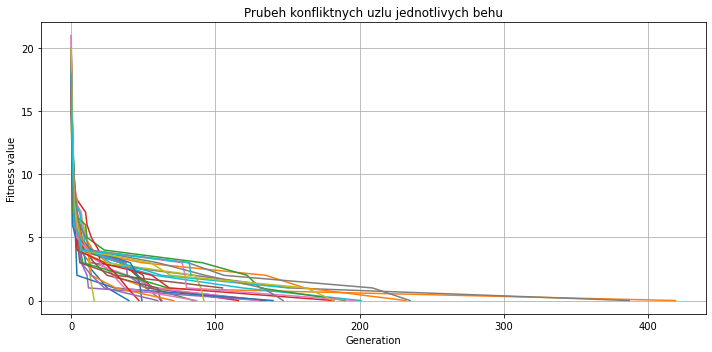

In [ ]:

# Provedeni genetickeho algoritmu
results = [genetic_algorithm(num_generations, population_size, crossover_probability, mutation_probability, all_fitness) for _ in range(num_runs)]

num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

# This is absolutely fucking dumb way to sum it all but I need it fast for the pojednani
fit_sum = 0
len_fit = 0
for i in range(num_runs):
  fit_sum += np.sum(results[i][3])
  len_fit+= len(results[i][3])
avg_fitness = fit_sum/len_fit


print(f'Done! Total success rate is {success_rate*100} % with average fitness {avg_fitness}')

# Plot prubehu nejlepsich reseni jednotlivych behu
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
    ax.plot(*zip(*results[i][2]) ) #,label=f"Run #{i}" )
#ax.legend()
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
plt.title('Prubeh konfliktnych uzlu jednotlivych behu')
plt.tight_layout()
plt.show()